In [1]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset,Sequence,Image
from utils.data_misc import make_dynamic_resize_transform
from utils.training_utils import PoseRegressionHead
SYSTEM_TOKENS = 190
TURN_TOKENS = 30
ORIG_H = 480
ORIG_W = 640
TOTAL_BUDGET = 32000#34000
dynamic_resize_transform = make_dynamic_resize_transform(SYSTEM_TOKENS,TURN_TOKENS,ORIG_H,ORIG_W,TOTAL_BUDGET-600)

val_dataset = load_dataset('Aasdfip/habitat_web_pose_val')['train']
val_dataset = val_dataset.cast_column('images',Sequence(Image()))
val_dataset.set_transform(dynamic_resize_transform)

In [2]:
import torch
import os
import textwrap
from PIL import Image
from safetensors.torch import load_file
from transformers import AutoModelForImageTextToText, AutoProcessor
from peft import PeftModel

# --- Import your custom components ---
from utils.training_utils import PoseRegressionHead, SpatialFeatureExtractor, get_image_token_indices

def load_analysis_model(base_model_id, checkpoint_path, device="cuda"):
    """
    Loads the Base Model, forces the Spatial Head weights (Nuclear Load), and wraps with LoRA.
    """
    print(f"--- Loading Model: {base_model_id} ---")
    model = AutoModelForImageTextToText.from_pretrained(
        base_model_id,
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        device_map=device,
    )
    processor = AutoProcessor.from_pretrained(base_model_id)
    
    # 1. Initialize Head (Architecture must match training)
    print("Initializing Pose Head...")
    # Ensure hidden_dim matches your config (3584 for Qwen2.5-VL-7B)
    model.spatial_head = PoseRegressionHead(hidden_dim=2048).to(model.device).to(torch.bfloat16)
    
    # 2. Nuclear Load of Head Weights
    # (Bypasses PEFT prefix issues)
    print(f"Forcing Head Weights from {checkpoint_path}...")
    safe_path = os.path.join(checkpoint_path, "adapter_model.safetensors")
    bin_path = os.path.join(checkpoint_path, "adapter_model.bin")
    
    if os.path.exists(safe_path):
        state_dict = load_file(safe_path)
    else:
        state_dict = torch.load(bin_path, map_location="cpu")
        
    head_sd = {}
    for k, v in state_dict.items():
        if "spatial_head" in k:
            # Strip potential prefixes
            clean_k = k.replace("base_model.model.spatial_head.", "").replace("spatial_head.", "")
            head_sd[clean_k] = v
            
    if head_sd:
        missing, unexpected = model.spatial_head.load_state_dict(head_sd, strict=True)
        print(f"Head Loaded. Missing: {missing}, Unexpected: {unexpected}")
    else:
        print("WARNING: No 'spatial_head' keys found in checkpoint. Head is random!")

    # 3. Load LoRA Adapters
    print("Loading LoRA...")
    model = PeftModel.from_pretrained(model, checkpoint_path)
    
    # 4. Attach Feature Extractor Hook
    extractor = SpatialFeatureExtractor(model, layer_index=-12)
    
    return model, processor, extractor

# --- Usage Example ---
# ckpt = "/path/to/checkpoint-500"
# model, processor, extractor = load_analysis_model(MODEL_ID, ckpt)
# result = predict_example(model, processor, extractor, dataset[0])
# print("Next Action:", result['generated_text'])
# print("Pred Translation:\n", result['pred_trans'])

In [3]:
from safetensors.torch import load_file
resume_path='/Projects/SG_VLN_HumanData/spatial_training/dump/allpose_training_v2/checkpoint-10800'
print(f"\n☢️  NUCLEAR LOAD: Forcing head weights from {resume_path}...")



# 2. Load State Dict
if os.path.exists(os.path.join(resume_path, "adapter_model.safetensors")):
    state_dict = load_file(os.path.join(resume_path, "adapter_model.safetensors"))
else:
    state_dict = torch.load(os.path.join(resume_path, "adapter_model.bin"), map_location="cpu")



☢️  NUCLEAR LOAD: Forcing head weights from /Projects/SG_VLN_HumanData/spatial_training/dump/allpose_training_v2/checkpoint-10800...


In [7]:
for k,v in state_dict.items():
    if 'spatial_head' in k:
        print(v)

tensor([ 0.0048, -0.0043, -0.0034,  ...,  0.0046, -0.0036,  0.0013],
       dtype=torch.bfloat16)
tensor([[-0.0481, -0.0171, -0.0569,  ..., -0.0098, -0.0212,  0.0120],
        [-0.0025,  0.0189, -0.0172,  ..., -0.0287,  0.0293, -0.0198],
        [-0.0166, -0.0204,  0.0161,  ...,  0.0231,  0.0195, -0.0050],
        ...,
        [ 0.0050, -0.0074,  0.0086,  ...,  0.0066, -0.0055,  0.0126],
        [-0.0269, -0.0040,  0.0209,  ...,  0.0094,  0.0386, -0.0060],
        [ 0.0145,  0.0199,  0.0079,  ...,  0.0026, -0.0280,  0.0320]],
       dtype=torch.bfloat16)
tensor([ 0.0045, -0.0042, -0.0017,  ...,  0.0024, -0.0063,  0.0006],
       dtype=torch.bfloat16)
tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.bfloat16)
tensor([-0.0047,  0.0025, -0.0036,  ...,  0.0035,  0.0017, -0.0067],
       dtype=torch.bfloat16)
tensor([[ 0.0199, -0.0291,  0.0126,  ..., -0.0078, -0.0500,  0.0791],
        [ 0.0270,  0.0132,  0.0044,  ..., -0.0250,  0.0194, -0.0298],
        [ 0.0098, -0.0060, -0.0125,  ..., 

In [3]:
MODEL_ID = "/Projects/SG_VLN_HumanData/SG-VLN/sft_pipeline/text_adapted_model"#,"Qwen/Qwen3-VL-2B-Instruct" # Or your specific VLM backbone
DEVICE = 'cuda:0'
model,processor,extractor = load_analysis_model(MODEL_ID,'/Projects/SG_VLN_HumanData/spatial_training/dump/allpose_training_v2/checkpoint-10800',DEVICE)
from utils.collators import PoseVLMCollator
collator = PoseVLMCollator(max_length=32000,processor=processor)

`torch_dtype` is deprecated! Use `dtype` instead!


--- Loading Model: /Projects/SG_VLN_HumanData/SG-VLN/sft_pipeline/text_adapted_model ---


The tokenizer you are loading from '/Projects/SG_VLN_HumanData/SG-VLN/sft_pipeline/text_adapted_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Initializing Pose Head...
Forcing Head Weights from /Projects/SG_VLN_HumanData/spatial_training/dump/allpose_training_v2/checkpoint-10800...
Head Loaded. Missing: [], Unexpected: []
Loading LoRA...


In [63]:
import random

def subsample_row(row, n_remove):
    """
    Randomly removes n_remove images and their associated messages from a row.
    """
    images = row["images"]
    messages = row["messages"]
    poses = row["pos_rots"]
    n_total = len(images)
    
    # Edge case: If requesting to remove more than exist, return cleared lists (keeping msg 0)
    if n_remove >= n_total:
        return {"images": [], "messages": [messages[0]]}
    
    # Edge case: If n_remove is 0, return original
    if n_remove <= 0:
        return row

    # 1. Decide which image INDICES to keep (sorted to preserve order)
    n_keep = n_total - n_remove
    keep_indices = sorted(random.sample(range(n_total), n_keep))

    # 2. Filter images
    new_images = [images[i] for i in keep_indices]
    new_poses = [poses[i] for i in keep_indices]
    # 3. Filter messages
    # Always keep the first message (index 0)
    new_messages = [messages[0]]
    
    for i in keep_indices:
        # Calculate the slice for the two messages associated with image i
        # Logic: Image 0 -> msgs 1,2 | Image 1 -> msgs 3,4 | Image i -> 2i+1, 2i+2
        start_idx = 2 * i + 1
        new_messages.extend(messages[start_idx : start_idx + 2])

    return {
        "images": new_images,
        "messages": new_messages,
        "pos_rots": new_poses
    }

Map: 100%|██████████| 1/1 [00:00<00:00,  3.40 examples/s]

Map: 100%|██████████| 1/1 [00:05<00:00,  5.40s/ examples]


Dataset({
    features: ['episode_id', 'scene_id', 'goal_category', 'goal_text', 'images', 'pos_rots', 'action_sequence', 'action_ids', 'messages'],
    num_rows: 1
})

In [4]:
i=18   #12 full fail 18 quite fail.  #7 success

# 13 interesting 49 near perfect 48 great
# 11 terrible
with torch.no_grad():
    inputs = collator(val_dataset.select(range(i,i+1))).to(DEVICE)
    # sample = val_dataset.select(range(i,i+1)).map(subsample_row,fn_kwargs={"n_remove":15})
    # inputs = collator(sample).to(DEVICE)
    outputs = model(**inputs)
    hidden_states = extractor.get_and_clear()
    
    # 5. Run Head
    batch_image_indices, _ = get_image_token_indices(inputs['input_ids'], processor)
    
    # Handle PEFT wrapping structure
    base = model.base_model if hasattr(model, "base_model") else model
    head = base.spatial_head
    
    with torch.no_grad():
        pred_t, pred_q = head(hidden_states, batch_image_indices)


DEBUG PRE-COLLATE: [(249, (341, 255))]
DEBUG PRE-COLLATE: [499]
debug post collate: thwtorch.Size([249, 3])


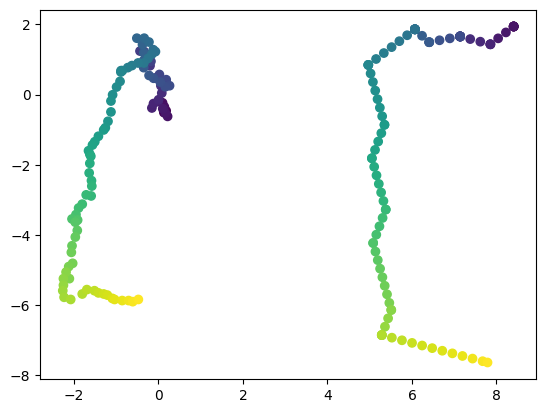

In [13]:
import matplotlib.pyplot as plt
import numpy as np
trajectory = pred_t.float().cpu().numpy()
gt_trajectory = inputs.get('gt_t', torch.empty(0)).float().cpu()
plt.scatter(trajectory[:,0],trajectory[:,2],c=np.arange(len(trajectory)))
plt.scatter(gt_trajectory[:,0],gt_trajectory[:,2],c=np.arange(len(gt_trajectory)))

Calculated Scale Factor: 1.6237


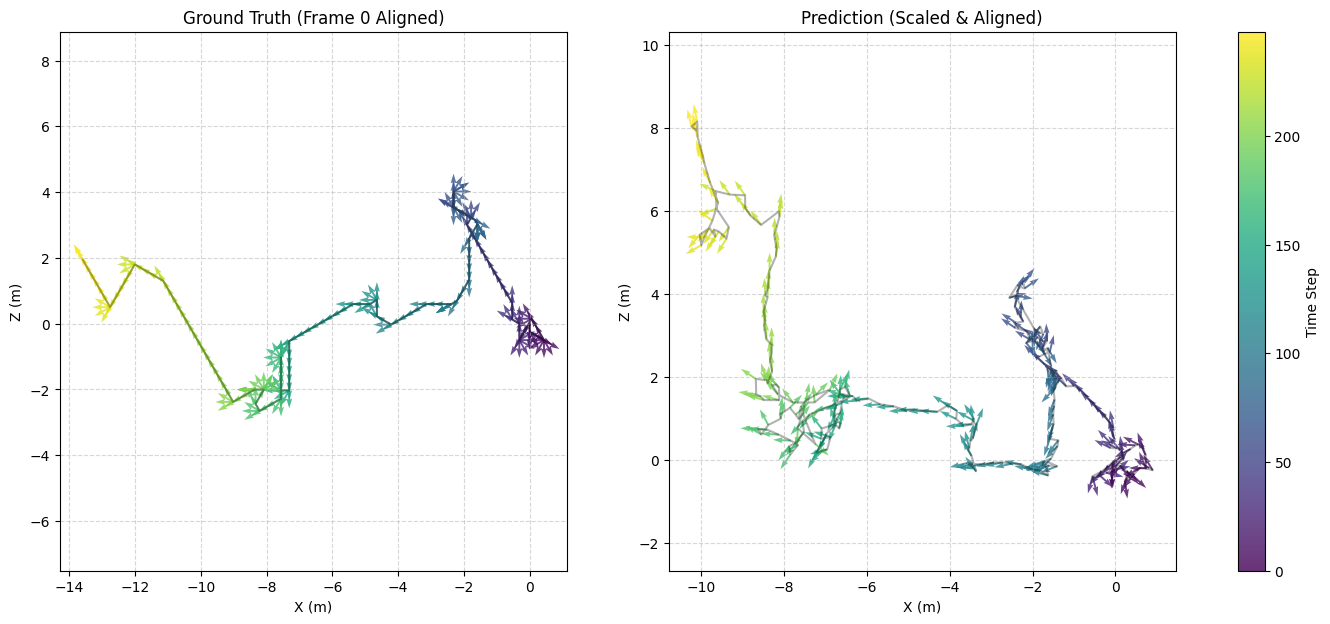

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- 1. Numpy Geometry Helpers ---
def q_inv_np(q):
    """Inverse of (N, 4) quaternion [x, y, z, w]"""
    inv = q.copy()
    inv[:, :3] = -inv[:, :3]
    return inv

def q_mult_np(q1, q2):
    """Multiply two quaternions (N, 4)"""
    x1, y1, z1, w1 = q1[:, 0], q1[:, 1], q1[:, 2], q1[:, 3]
    x2, y2, z2, w2 = q2[:, 0], q2[:, 1], q2[:, 2], q2[:, 3]
    
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.stack([x, y, z, w], axis=1)

def q_rot_vec_np(q, v):
    """Rotate vector v (N, 3) by q (N, 4)"""
    q_vec = q[:, :3]
    q_w = q[:, 3:]
    t = 2.0 * np.cross(q_vec, v)
    return v + q_w * t + np.cross(q_vec, t)

# --- 2. Alignment Logic ---
def align_and_process(pred_t, pred_q, gt_t, gt_q):
    # Convert to Numpy
    pt = pred_t.float().cpu().numpy()
    pq = pred_q.float().cpu().numpy()
    gt = gt_t.float().cpu().numpy()
    gq = gt_q.float().cpu().numpy()
    
    # 1. Zero-Center (Anchor to first position)
    pt_centered = pt - pt[0]
    gt_centered = gt - gt[0]
    
    # 2. Un-Rotate (Anchor to first orientation)
    # Rotate trajectory so Frame 0 faces Identity
    pq0_inv = q_inv_np(pq[0:1])
    gq0_inv = q_inv_np(gq[0:1])
    
    pt_local = q_rot_vec_np(np.repeat(pq0_inv, len(pt), axis=0), pt_centered)
    gt_local = q_rot_vec_np(np.repeat(gq0_inv, len(gt), axis=0), gt_centered)
    
    # Also rotate the quaternions themselves to be relative to Frame 0
    pq_local = q_mult_np(np.repeat(pq0_inv, len(pq), axis=0), pq)
    gq_local = q_mult_np(np.repeat(gq0_inv, len(gq), axis=0), gq)

    # 3. Least Squares Scaling
    # s = (p . g) / (p . p)
    p_flat = pt_local.flatten()
    g_flat = gt_local.flatten()
    scale = np.dot(p_flat, g_flat) / (np.dot(p_flat, p_flat) + 1e-8)
    
    print(f"Calculated Scale Factor: {scale:.4f}")
    
    pt_aligned = pt_local * scale
    
    return pt_aligned, pq_local, gt_local, gq_local

# --- 3. Run Analysis ---
pt_final, pq_final, gt_final, gq_final = align_and_process(pred_t, pred_q, inputs['gt_t'], inputs['gt_q'])

# --- 4. Plotting ---
def plot_trajectory_with_heading(t, q, ax, title):
    # Extract X (0) and Z (2) for top-down view
    x = t[:, 0]
    z = t[:, 2]
    
    # Calculate Heading Vectors
    # Assume standard Habitat Camera: Forward is -Z (0, 0, -1)
    # If your data is +Z, change to [0, 0, 1]
    forward_local = np.array([0, 0, -1]) 
    forward_local = np.tile(forward_local, (len(q), 1))
    
    # Rotate forward vector by quaternion
    heading_vecs = q_rot_vec_np(q, forward_local)
    
    # Extract U, V components for Quiver (X and Z axes)
    u = heading_vecs[:, 0]
    v = heading_vecs[:, 2]
    
    # Color by time
    colors = np.arange(len(x))
    
    # Plot Path
    ax.plot(x, z, 'k-', alpha=0.3, label='Path')
    
    # Plot Headings
    # scale=None autoscales, units='xy' makes arrow length proportional to data units
    q = ax.quiver(x, z, u, v, colors, cmap='viridis', scale=None, alpha=0.8)
    
    ax.set_title(title)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Z (m)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.axis('equal') # Crucial for geometry
    return q

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# GT
plot_trajectory_with_heading(gt_final, gq_final, ax1, "Ground Truth (Frame 0 Aligned)")
# Pred
q_art = plot_trajectory_with_heading(pt_final, pq_final, ax2, "Prediction (Scaled & Aligned)")

# Colorbar
cbar = fig.colorbar(q_art, ax=[ax1, ax2], location='right', fraction=0.05)
cbar.set_label('Time Step')

plt.show()

In [ ]:
example

In [ ]:
# 4. Extract Features
hidden_states = extractor.get_and_clear()

# 5. Run Head
batch_image_indices, _ = get_image_token_indices(batch['input_ids'], processor)

# Handle PEFT wrapping structure
base = model.base_model if hasattr(model, "base_model") else model
head = base.spatial_head

with torch.no_grad():
    pred_t, pred_q = head(hidden_states, batch_image_indices)